<a href="https://colab.research.google.com/github/s1102498/DeepLearning/blob/main/Copia_di_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Google drive loading**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive




$\color{red}{\text{WARNING:}}$ remember to set GPU in the Notebook settings


# **Data Import**

**Data in one folder**:
If we have one folder that containes all the images, a strategy could be to add a function that directly extrapolates and puts them in a tensor

In [ ]:
#Let's start by importing the libraries needed 
import os
from sklearn.utils import shuffle
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
import numpy as np


def preprocessing(path,img_rows, img_cols):
 imgs_array = []
 label_array = []
 immagini = [j for j in sorted(os.listdir(path))]
 for image in immagini:
   images = load_img(os.path.join(path,image), 
                         target_size = (img_rows, img_cols))
   if image.startswith('cat'): #if the image's name starts with "cat" then the label will be 0 otherwise 1
     label_array.append(0)
     x = img_to_array(images)
     x = preprocess_input(x) #images are processed according to the preprocessing of the fine-tuned network
     imgs_array.append(x) #images are added to a list
   else: 
     label_array.append(1)
     x = img_to_array(images)
     x = preprocess_input(x)
     imgs_array.append(x)

 imgs_array = np.asarray(imgs_array) #data are converted to an array
 label_array = np.asarray(label_array)

 
 return imgs_array, label_array



In [ ]:
from sklearn.utils import shuffle
# Aggiungi la cartella nel tuo Drive
path = "/content/gdrive/My Drive/dog_and_cat" #path of the folder
immg_rows = 224
immg_cols = 224     
new_array, new_label = preprocessing(path, immg_rows, immg_cols)
new_array, new_label = shuffle(new_array,new_label,random_state=24) #Random state allows to obtain the same shuffle over time


(1033, 224, 224, 3)
(1033,)


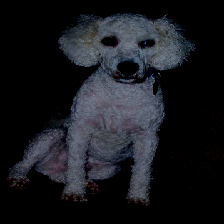

1


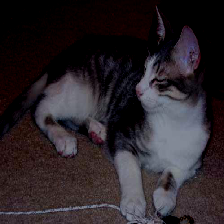

0


In [ ]:
#Let's see if we are doing well
from google.colab.patches import cv2_imshow
print(new_array.shape)
print(new_label.shape)
cv2_imshow(new_array[3,:,:,:])
print(new_label[3])
cv2_imshow(new_array[0,:,:,:])
print(new_label[0])

# **Train/Validation/Test Split --> Hold-out**

[link text](https://)**Hold-out** is when you split up your dataset into a ‘train’ 'validation' and ‘test’ set. The training set is what the model is trained on, and the test set is used to see how well that model performs on unseen data
![alt text](https://drive.google.com/uc?id=1L0na_K4l6Fk3s9KjMMzy7RHjAajrydJU)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(new_array,new_label, test_size=0.30, stratify=new_label, random_state=42)
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X_train,y_train, test_size=0.20, stratify=y_train, random_state=42)



# **Data Augmentation**

**Offline data augmentation** : Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. Usually the augmentation is performed on the training set only.


![alt text](https://drive.google.com/uc?id=1eY7K5ORSuu0ZMwJE_lwkt_ZI-gToUbPo)

This approach is usefull when the dataset is very poor --> it has some drawbacks: we haven’t exactly increased the ability of our model to generalize. To do that we should implement an 
**in-place/on-the-fly data augmentation**

In [ ]:
#This is just an example of data augmentation: there are so many functions that you can use!
import tensorflow as tf

def flip_axis(x, axis):
    cp = np.copy(x)
    cp = np.asarray(cp).swapaxes(axis, 0)
    cp = cp[::-1, ...]
    cp = cp.swapaxes(0, axis)
    return cp

def augment_data(dataset, dataset_labels, augementation_factor=1, use_flip_axis=True, use_random_rotation=True, use_random_shear=True, use_random_shift=True):
    augmented_image = []
    augmented_image_labels = []
    
    for num in range (0, dataset.shape[0]):

       for i in range(0, augementation_factor):
			# original image:
            augmented_image.append(dataset[num])
            augmented_image_labels.append(dataset_labels[num])
            # flipping
            if use_flip_axis:
                augmented_image.append(flip_axis(dataset[num],1))
                augmented_image_labels.append(dataset_labels[num]) 
            #random rotation
            if use_random_rotation:
                augmented_image.append(tf.contrib.keras.preprocessing.image.random_rotation(dataset[num], 20, row_axis=0, col_axis=1, channel_axis=2,fill_mode='constant'))
                augmented_image_labels.append(dataset_labels[num])
            #random spatial shear
            if use_random_shear:
                augmented_image.append(tf.contrib.keras.preprocessing.image.random_shear(dataset[num], 0.2, row_axis=0, col_axis=1, channel_axis=2))
                augmented_image_labels.append(dataset_labels[num])
            #random spatial shift
            if use_random_shift:
                augmented_image.append(tf.contrib.keras.preprocessing.image.random_shift(dataset[num], 0.2, 0.2, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant'))
                augmented_image_labels.append(dataset_labels[num])

    return np.array(augmented_image), np.array(augmented_image_labels)


In [ ]:
img_augmented, label_augmented = augment_data(Xtrain, ytrain, augementation_factor=1, use_flip_axis=True,
                                                  use_random_rotation=False, use_random_shear=False, use_random_shift=False)
'''
in this case we performed the only flipping transformation. If we wanna perform the others,
you can just change the False with True
'''


'\nin this case we performed the only flipping transformation. If we wanna perform the others,\nyou can just change the False with True\n'

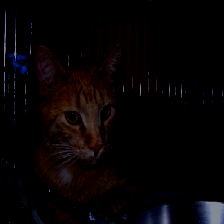

0


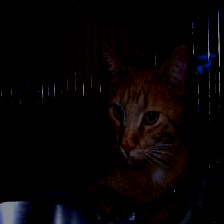

0


In [ ]:
cv2_imshow(img_augmented[0,:,:,:])
print(label_augmented[0])
cv2_imshow(img_augmented[1,:,:,:])
print(label_augmented[1])


# **Fine tuning**

The task of fine-tuning a network is to tweak the parameters of an already trained network so that it adapts to the new task at hand --> the initial layers learn very general features and as we go higher up the network, the layers tend to learn patterns more specific to the task it is being trained on. Thus, for fine-tuning, we want to keep the initial layers intact ( or freeze them ) and retrain the later layers for our task.

**Example of fine tuning**: Starting from the loading of imagenet weights, we freeze the 4 blocks of the VGG16. The last 4 layers along with the top layers are trainable.

![alt text](https://drive.google.com/uc?id=1SmTzEk8c1tXUHjWgtgdpoiVRN1KZDXXp)



In [ ]:
#First, we will load a VGG model without the top layers (the fully connected ones)
from keras.applications import VGG16
from keras import models
from keras import layers, Sequential
from keras import optimizers

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(immg_rows, immg_cols, 3))

#Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

model = Sequential() #A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
model.add(vgg_conv)
          
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))



58892288/58889256 [==============================] - 1s 0us/step
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f4f7999c8d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4f79734cf8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4f796cc080> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4f796cc780> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4f700c54a8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4f700c5c50> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4f700d0438> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4f700d0be0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4f700d9a58> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4f700d9b00> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4f700e2748> Fals

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [ ]:
from keras.utils.np_utils import to_categorical

num_epochs = 30
ytrain = to_categorical(ytrain, num_classes = 2) #Converts a class vector (integers) to binary class matrix-->this because we have 2 neurons at the end
yvalid = to_categorical(yvalid, num_classes = 2)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),metrics=[ "accuracy"]) 
history = model.fit(Xtrain, ytrain,
                    epochs=num_epochs, batch_size=32, validation_data=(Xvalid, yvalid), verbose=1)



Epoch 1/30
19/19 [==============================] - 4s 229ms/step - loss: 0.9029 - accuracy: 0.6073 - val_loss: 0.3470 - val_accuracy: 0.8414
Epoch 2/30
19/19 [==============================] - 3s 154ms/step - loss: 0.4758 - accuracy: 0.7837 - val_loss: 0.1315 - val_accuracy: 0.9586
Epoch 3/30
19/19 [==============================] - 3s 155ms/step - loss: 0.3010 - accuracy: 0.8720 - val_loss: 0.0694 - val_accuracy: 0.9793
Epoch 4/30
19/19 [==============================] - 3s 156ms/step - loss: 0.2044 - accuracy: 0.9118 - val_loss: 0.0648 - val_accuracy: 0.9862
Epoch 5/30
19/19 [==============================] - 3s 156ms/step - loss: 0.1698 - accuracy: 0.9118 - val_loss: 0.0553 - val_accuracy: 0.9793
Epoch 6/30
19/19 [==============================] - 3s 156ms/step - loss: 0.1758 - accuracy: 0.9308 - val_loss: 0.0362 - val_accuracy: 0.9793
Epoch 7/30
19/19 [==============================] - 3s 156ms/step - loss: 0.1191 - accuracy: 0.9498 - val_loss: 0.0378 - val_accuracy: 0.9793
Epoch 

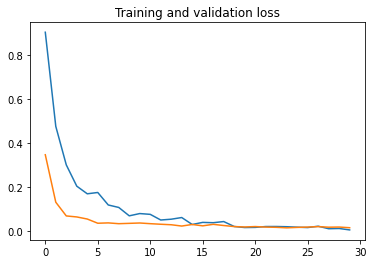

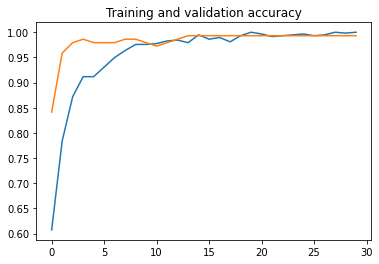

In [ ]:
import matplotlib.pyplot as plt

epochs = num_epochs
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")

In [ ]:
# to save model and weights
'''
model_json = model.to_json()
with open("results/model.json", "w") as json_file:
    json_file.write(model_json)
path = "/content/gdrive/My Drive"
model.save_weights(path + 'model_weights.h5')

model.save(path + 'model')
'''

'\nmodel_json = model.to_json()\nwith open("results/model.json", "w") as json_file:\n    json_file.write(model_json)\n        \nmodel.save_weights(\'results/model_weights.h5\')\n\nmodel.save(\'results/model\')\n'

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       155
           1       0.98      0.97      0.98       155

    accuracy                           0.98       310
   macro avg       0.98      0.98      0.98       310
weighted avg       0.98      0.98      0.98       310

accuracy: 0.9774193548387097


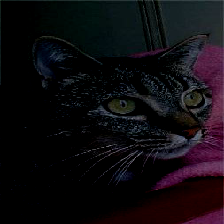

0


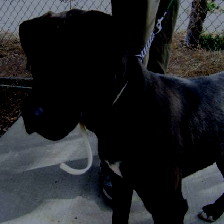

1


In [ ]:
#results:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
y_pred = model.predict_classes(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred))
a = accuracy_score(y_test, y_pred)
print("accuracy:",a)
cv2_imshow(X_test[0,:,:,:])
print(y_pred[0])
cv2_imshow(X_test[4,:,:,:])
print(y_pred[4])

In [ ]:
y_pred = model.predict_classes(X_test)
print(y_pred)

[0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 1
 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0
 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0
 0 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 0
 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0
 1 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1
 0 0 0 1 1 0 1 1 1 1 1 0 0 0]


In [ ]:
y_predicted = model.predict(X_test) #predict will return the scores of the model and predict_class will return the class of your predictions. Although it seems similar there are some differences:
pred_class = np.argmax(y_predicted, axis=1)  #argmax tra le colonne (axis =1)
print(y_predicted)
print(pred_class)

[[9.99999881e-01 8.62978524e-08]
 [9.97053623e-01 2.94637983e-03]
 [9.82786000e-01 1.72139704e-02]
 [1.59784948e-04 9.99840140e-01]
 [1.70781959e-07 9.99999881e-01]
 [9.99999523e-01 4.39460621e-07]
 [2.59386197e-05 9.99974012e-01]
 [1.00000000e+00 5.92472631e-08]
 [3.17371587e-08 1.00000000e+00]
 [2.44476155e-07 9.99999762e-01]
 [3.34913377e-04 9.99665141e-01]
 [9.99991298e-01 8.68669395e-06]
 [8.30581903e-01 1.69418156e-01]
 [8.34580547e-08 9.99999881e-01]
 [9.99988317e-01 1.17386899e-05]
 [9.99987245e-01 1.27101357e-05]
 [3.48716594e-06 9.99996543e-01]
 [9.99997377e-01 2.62606000e-06]
 [1.00000000e+00 1.67370082e-08]
 [2.43388745e-03 9.97566104e-01]
 [1.01882074e-06 9.99998927e-01]
 [1.64510111e-05 9.99983549e-01]
 [6.21376501e-04 9.99378562e-01]
 [8.45428804e-05 9.99915481e-01]
 [9.95732248e-01 4.26776661e-03]
 [9.99999046e-01 9.12728012e-07]
 [6.76671306e-08 9.99999881e-01]
 [1.30028681e-07 9.99999881e-01]
 [9.99721348e-01 2.78663356e-04]
 [1.00000000e+00 3.31326078e-08]
 [9.595724

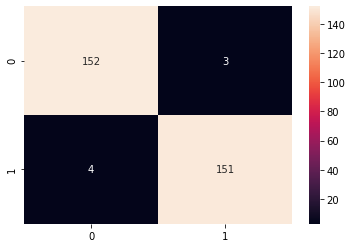

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf = confusion_matrix(y_test, pred_class)
#print(conf)
sns.heatmap(conf, annot=True, fmt="d")

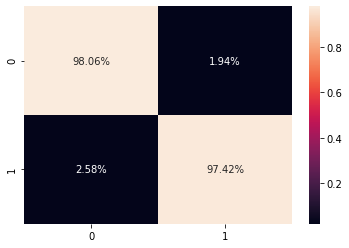

In [ ]:
cm = conf.astype('float') / conf.sum(axis=1)
sns.heatmap(cm, annot=True, 
            fmt='.2%')